In [1]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.utils import shuffle
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

In [2]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU instead.")

Using GPU: NVIDIA GeForce RTX 4080


# Data Preprocessing

In [51]:
df = pd.read_pickle("./cdcdata.pkl")

### One-hot encoding

In [52]:
def one_hot_encode_features(df, columns_to_encode):
    for column in columns_to_encode:
        if column not in df.columns:
            raise ValueError(f"Column '{column}' not found in DataFrame.")

    df_encoded = pd.get_dummies(df, columns=columns_to_encode)

    return df_encoded

columns_to_encode = ['current_status', 'sex', 'age_group', 'race_ethnicity_combined', 'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn']
df_encoded = one_hot_encode_features(df, columns_to_encode)

### Get rid of all columns related with date/time, and keep only one of any column with binary outcome

In [53]:
cols_to_drop = ['cdc_case_earliest_dt', 'cdc_report_dt', 'pos_spec_dt', 'onset_dt', 'hosp_yn_No', 'icu_yn_No', 'death_yn_No', 'medcond_yn_No']
df_dropped = df_encoded.drop(cols_to_drop, axis=1)
df = df_dropped

In [54]:
df # This is how dataframe looks

,current_status_Laboratory-confirmed case,current_status_Probable Case,sex_Female,sex_Male,sex_Other,age_group_0 - 9 Years,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,...,"race_ethnicity_combined_Asian, Non-Hispanic","race_ethnicity_combined_Black, Non-Hispanic",race_ethnicity_combined_Hispanic/Latino,"race_ethnicity_combined_Multiple/Other, Non-Hispanic","race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic","race_ethnicity_combined_White, Non-Hispanic",hosp_yn_Yes,icu_yn_Yes,death_yn_Yes,medcond_yn_Yes
6,True,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
11,True,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,True
30,True,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,True
36,True,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,True
40,True,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18336515,True,False,True,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
18336519,True,False,True,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
18336523,True,False,True,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
18336525,True,False,True,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


death_yn_Yes
False    701401
True      28786
Name: count, dtype: int64
death_yn_Yes
False    0.960577
True     0.039423
Name: count, dtype: float64


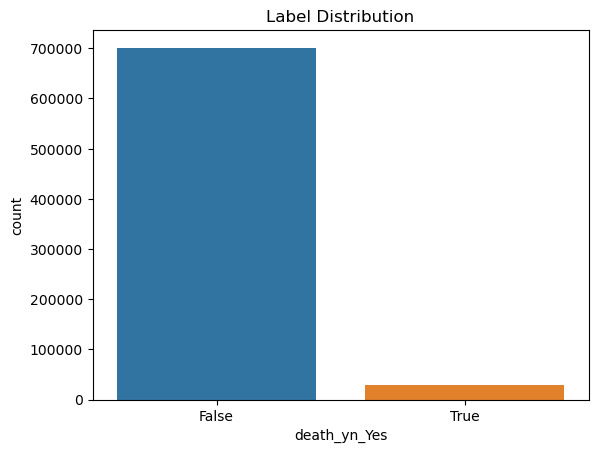

In [7]:
label_counts = df['death_yn_Yes'].value_counts()
print(label_counts)

label_proportions = label_counts / len(df)
print(label_proportions)


sns.countplot(x=df['death_yn_Yes'])
plt.title('Label Distribution')
plt.show()

In [8]:
features = df.drop('death_yn_Yes', axis=1)
labels = df['death_yn_Yes']
features_tensor = torch.tensor(features.values, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32)

In [9]:
X = features_tensor.numpy()
y = labels_tensor.numpy()

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)  # making the split 8:1:1

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [10]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 128  

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Model Architecture

In [11]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        logits = self.linear(x)
        probabilities = torch.sigmoid(logits)
        return probabilities

In [12]:
input_size = 24
model = LogisticRegressionModel(input_size)
model = model.to(device)

loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100

In [13]:
def train_model(model, train_loader, val_loader, loss_function, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  
        running_loss = 0.0
        
        for batch_features, batch_labels in train_loader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)
            optimizer.zero_grad()  
            outputs = model(batch_features) 
            loss = loss_function(outputs.squeeze(), batch_labels.float())  
            loss.backward()  
            optimizer.step()  
            
            running_loss += loss.item() * batch_features.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Evaluation on the validation set
        val_accuracy = evaluate_model(model, val_loader)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    
    print("Training complete")


def evaluate_model(model, data_loader):
    model.eval()  
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():  
        for batch_features, batch_labels in data_loader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)
            outputs = model(batch_features)
            # predicted = torch.round(torch.sigmoid(outputs.squeeze()))  
            predicted = torch.round(outputs.squeeze())
            correct_predictions += (predicted == batch_labels).sum().item()
            total_predictions += batch_labels.size(0)
    
    accuracy = correct_predictions / total_predictions
    return accuracy

In [32]:
train_model(model, train_loader, val_loader, loss_function, optimizer, num_epochs=10)

test_accuracy = evaluate_model(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/10, Loss: 0.0866, Validation Accuracy: 0.9669
Epoch 2/10, Loss: 0.0817, Validation Accuracy: 0.9668
Epoch 3/10, Loss: 0.0817, Validation Accuracy: 0.9666
Epoch 4/10, Loss: 0.0817, Validation Accuracy: 0.9668
Epoch 5/10, Loss: 0.0817, Validation Accuracy: 0.9667
Epoch 6/10, Loss: 0.0817, Validation Accuracy: 0.9664
Epoch 7/10, Loss: 0.0818, Validation Accuracy: 0.9666
Epoch 8/10, Loss: 0.0817, Validation Accuracy: 0.9668
Epoch 9/10, Loss: 0.0817, Validation Accuracy: 0.9665
Epoch 10/10, Loss: 0.0817, Validation Accuracy: 0.9667
Training complete
Test Accuracy: 0.9676


# Defining Better Metrics

### Just an example illustrating how ROC-AUC works

In [14]:
import numpy as np
from sklearn.metrics import roc_auc_score
y_true = np.array([0]*950 + [1]*50) 
y_pred = np.zeros_like(y_true)  # Predicts false for all

# Calculate the Accuracy
correct_predictions = np.sum(y_true == y_pred)
total_predictions = len(y_true)
accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy:.4f}")

# Calculate the AUC-ROC score
auc_roc_score = roc_auc_score(y_true, y_pred)
print(f"AUC-ROC Score: {auc_roc_score:.4f}")

Accuracy: 0.9500
AUC-ROC Score: 0.5000


In [15]:
def calculate_roc_score(model, test_loader):
    all_preds = []
    true_labels = []
    model.eval()  
    with torch.no_grad():  
        for inputs, labels in test_loader:
            inputs = inputs.to(device)  

            outputs = model(inputs)

            all_preds.extend(outputs.squeeze().cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    auc_roc_score = roc_auc_score(true_labels, all_preds)
    print(f"AUC-ROC Score: {auc_roc_score:.4f}")
calculate_roc_score(model, test_loader)

AUC-ROC Score: 0.2485


# Drop hosp_yn_yes

In [35]:
df = pd.read_pickle("./cdcdata.pkl")
columns_to_encode = ['current_status', 'sex', 'age_group', 'race_ethnicity_combined', 'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn']
df_encoded = one_hot_encode_features(df, columns_to_encode)
cols_to_drop = ['cdc_case_earliest_dt', 'cdc_report_dt', 'pos_spec_dt', 'onset_dt', 'hosp_yn_No', 'icu_yn_No', 'death_yn_No', 'medcond_yn_No', 'hosp_yn_Yes']
df_dropped = df_encoded.drop(cols_to_drop, axis=1)
df = df_dropped

In [36]:
df

,current_status_Laboratory-confirmed case,current_status_Probable Case,sex_Female,sex_Male,sex_Other,age_group_0 - 9 Years,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,...,"race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic","race_ethnicity_combined_Asian, Non-Hispanic","race_ethnicity_combined_Black, Non-Hispanic",race_ethnicity_combined_Hispanic/Latino,"race_ethnicity_combined_Multiple/Other, Non-Hispanic","race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic","race_ethnicity_combined_White, Non-Hispanic",icu_yn_Yes,death_yn_Yes,medcond_yn_Yes
6,True,False,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
11,True,False,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
30,True,False,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
36,True,False,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
40,True,False,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18336515,True,False,True,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
18336519,True,False,True,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
18336523,True,False,True,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
18336525,True,False,True,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [37]:
features = df.drop('death_yn_Yes', axis=1)
labels = df['death_yn_Yes']
features_tensor = torch.tensor(features.values, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32)

In [38]:
X = features_tensor.numpy()
y = labels_tensor.numpy()

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)  # making the split 8:1:1

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [39]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 128  

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [40]:
input_size = 23
model = LogisticRegressionModel(input_size)
model = model.to(device)

loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100

In [41]:
train_model(model, train_loader, val_loader, loss_function, optimizer, num_epochs=10)

test_accuracy = evaluate_model(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/10, Loss: 0.0970, Validation Accuracy: 0.9665
Epoch 2/10, Loss: 0.0901, Validation Accuracy: 0.9666
Epoch 3/10, Loss: 0.0901, Validation Accuracy: 0.9666
Epoch 4/10, Loss: 0.0901, Validation Accuracy: 0.9664
Epoch 5/10, Loss: 0.0901, Validation Accuracy: 0.9666
Epoch 6/10, Loss: 0.0901, Validation Accuracy: 0.9663
Epoch 7/10, Loss: 0.0901, Validation Accuracy: 0.9666
Epoch 8/10, Loss: 0.0901, Validation Accuracy: 0.9665
Epoch 9/10, Loss: 0.0901, Validation Accuracy: 0.9664
Epoch 10/10, Loss: 0.0901, Validation Accuracy: 0.9667
Training complete
Test Accuracy: 0.9678


In [42]:
calculate_roc_score(model, test_loader)

AUC-ROC Score: 0.9538


# Drop icu_yn_yes

In [43]:
df = pd.read_pickle("./cdcdata.pkl")
columns_to_encode = ['current_status', 'sex', 'age_group', 'race_ethnicity_combined', 'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn']
df_encoded = one_hot_encode_features(df, columns_to_encode)
cols_to_drop = ['cdc_case_earliest_dt', 'cdc_report_dt', 'pos_spec_dt', 'onset_dt', 'hosp_yn_No', 'icu_yn_No', 'death_yn_No', 'medcond_yn_No', 'icu_yn_Yes']
df_dropped = df_encoded.drop(cols_to_drop, axis=1)
df = df_dropped

In [44]:
df

,current_status_Laboratory-confirmed case,current_status_Probable Case,sex_Female,sex_Male,sex_Other,age_group_0 - 9 Years,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,...,"race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic","race_ethnicity_combined_Asian, Non-Hispanic","race_ethnicity_combined_Black, Non-Hispanic",race_ethnicity_combined_Hispanic/Latino,"race_ethnicity_combined_Multiple/Other, Non-Hispanic","race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic","race_ethnicity_combined_White, Non-Hispanic",hosp_yn_Yes,death_yn_Yes,medcond_yn_Yes
6,True,False,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
11,True,False,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,True
30,True,False,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,True
36,True,False,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,True
40,True,False,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18336515,True,False,True,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
18336519,True,False,True,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
18336523,True,False,True,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
18336525,True,False,True,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [45]:
features = df.drop('death_yn_Yes', axis=1)
labels = df['death_yn_Yes']
features_tensor = torch.tensor(features.values, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32)

In [46]:
X = features_tensor.numpy()
y = labels_tensor.numpy()

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)  # making the split 8:1:1

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [47]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 128  

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [48]:
input_size = 23
model = LogisticRegressionModel(input_size)
model = model.to(device)

loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100

In [49]:
train_model(model, train_loader, val_loader, loss_function, optimizer, num_epochs=10)

test_accuracy = evaluate_model(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/10, Loss: 0.1021, Validation Accuracy: 0.9616
Epoch 2/10, Loss: 0.0945, Validation Accuracy: 0.9618
Epoch 3/10, Loss: 0.0945, Validation Accuracy: 0.9618
Epoch 4/10, Loss: 0.0946, Validation Accuracy: 0.9618
Epoch 5/10, Loss: 0.0946, Validation Accuracy: 0.9617
Epoch 6/10, Loss: 0.0945, Validation Accuracy: 0.9618
Epoch 7/10, Loss: 0.0945, Validation Accuracy: 0.9619
Epoch 8/10, Loss: 0.0945, Validation Accuracy: 0.9617
Epoch 9/10, Loss: 0.0946, Validation Accuracy: 0.9583
Epoch 10/10, Loss: 0.0945, Validation Accuracy: 0.9617
Training complete
Test Accuracy: 0.9614


In [50]:
calculate_roc_score(model, test_loader)

AUC-ROC Score: 0.9499


# Drop both icu_yn_Yes and hosp_yn_Yes

In [51]:
df = pd.read_pickle("./cdcdata.pkl")
columns_to_encode = ['current_status', 'sex', 'age_group', 'race_ethnicity_combined', 'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn']
df_encoded = one_hot_encode_features(df, columns_to_encode)
cols_to_drop = ['cdc_case_earliest_dt', 'cdc_report_dt', 'pos_spec_dt', 'onset_dt', 'hosp_yn_No', 'icu_yn_No', 'death_yn_No', 'medcond_yn_No', 'hosp_yn_Yes', 'icu_yn_Yes']
df_dropped = df_encoded.drop(cols_to_drop, axis=1)
df = df_dropped

In [52]:
df

,current_status_Laboratory-confirmed case,current_status_Probable Case,sex_Female,sex_Male,sex_Other,age_group_0 - 9 Years,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,...,age_group_80+ Years,"race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic","race_ethnicity_combined_Asian, Non-Hispanic","race_ethnicity_combined_Black, Non-Hispanic",race_ethnicity_combined_Hispanic/Latino,"race_ethnicity_combined_Multiple/Other, Non-Hispanic","race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic","race_ethnicity_combined_White, Non-Hispanic",death_yn_Yes,medcond_yn_Yes
6,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
11,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
30,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
36,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
40,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18336515,True,False,True,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
18336519,True,False,True,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
18336523,True,False,True,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
18336525,True,False,True,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [53]:
features = df.drop('death_yn_Yes', axis=1)
labels = df['death_yn_Yes']
features_tensor = torch.tensor(features.values, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32)

In [54]:
X = features_tensor.numpy()
y = labels_tensor.numpy()

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)  # making the split 8:1:1

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [55]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 128  

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [58]:
input_size = 22
model = LogisticRegressionModel(input_size)
model = model.to(device)

loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100

In [59]:
train_model(model, train_loader, val_loader, loss_function, optimizer, num_epochs=10)

test_accuracy = evaluate_model(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/10, Loss: 0.1273, Validation Accuracy: 0.9617
Epoch 2/10, Loss: 0.1208, Validation Accuracy: 0.9617
Epoch 3/10, Loss: 0.1207, Validation Accuracy: 0.9617
Epoch 4/10, Loss: 0.1207, Validation Accuracy: 0.9616
Epoch 5/10, Loss: 0.1208, Validation Accuracy: 0.9616
Epoch 6/10, Loss: 0.1208, Validation Accuracy: 0.9617
Epoch 7/10, Loss: 0.1207, Validation Accuracy: 0.9617
Epoch 8/10, Loss: 0.1207, Validation Accuracy: 0.9618
Epoch 9/10, Loss: 0.1207, Validation Accuracy: 0.9618
Epoch 10/10, Loss: 0.1208, Validation Accuracy: 0.9617
Training complete
Test Accuracy: 0.9613


In [60]:
calculate_roc_score(model, test_loader)

AUC-ROC Score: 0.8940


# Customize Loss Function

In [16]:
df = pd.read_pickle("./cdcdata.pkl")
columns_to_encode = ['current_status', 'sex', 'age_group', 'race_ethnicity_combined', 'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn']
df_encoded = one_hot_encode_features(df, columns_to_encode)
cols_to_drop = ['cdc_case_earliest_dt', 'cdc_report_dt', 'pos_spec_dt', 'onset_dt', 'hosp_yn_No', 'icu_yn_No', 'death_yn_No', 'medcond_yn_No', 'hosp_yn_Yes', 'icu_yn_Yes']
df_dropped = df_encoded.drop(cols_to_drop, axis=1)
df = df_dropped

In [17]:
features = df.drop('death_yn_Yes', axis=1)
labels = df['death_yn_Yes']
features_tensor = torch.tensor(features.values, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32)

In [18]:
X = features_tensor.numpy()
y = labels_tensor.numpy()

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)  # making the split 8:1:1

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [19]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 128  

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
import torch.nn.functional as F

In [21]:
def calculate_class_weights(labels):
    class_counts = torch.bincount(labels.long())
    weights = 1. / class_counts.float()
    weights = weights / weights.min()
    return weights

In [22]:
class WeightedBCELoss(torch.nn.Module):
    def __init__(self, weights, penalty_factor=2.0):
        super(WeightedBCELoss, self).__init__()
        self.weights = weights
        self.penalty_factor = penalty_factor

    def forward(self, outputs, targets):
        weights = self.weights.to(outputs.device)
        bce_loss = F.binary_cross_entropy_with_logits(outputs, targets, reduction='none')
        weighted_loss = bce_loss * weights[targets.long()]
        probabilities = torch.sigmoid(outputs)
        predicted_classes = probabilities > 0.5 

        false_negatives = (predicted_classes == 0) & (targets == 1)

        penalties = torch.zeros_like(weighted_loss)
        penalties[false_negatives] = weighted_loss[false_negatives] * self.penalty_factor

        total_loss = weighted_loss + penalties
        return total_loss.mean()

In [35]:
input_size = 22
model = LogisticRegressionModel(input_size)
model = model.to(device)

class_weights = calculate_class_weights(y_train_tensor)
loss_function = WeightedBCELoss(weights=class_weights, penalty_factor=2.0)
#loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100

In [36]:
train_model(model, train_loader, val_loader, loss_function, optimizer, num_epochs=20)

test_accuracy = evaluate_model(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/20, Loss: 0.6224, Validation Accuracy: 0.8083
Epoch 2/20, Loss: 0.5993, Validation Accuracy: 0.8077
Epoch 3/20, Loss: 0.5965, Validation Accuracy: 0.8077
Epoch 4/20, Loss: 0.5953, Validation Accuracy: 0.8077
Epoch 5/20, Loss: 0.5947, Validation Accuracy: 0.8072
Epoch 6/20, Loss: 0.5944, Validation Accuracy: 0.8076
Epoch 7/20, Loss: 0.5941, Validation Accuracy: 0.8076
Epoch 8/20, Loss: 0.5939, Validation Accuracy: 0.8076
Epoch 9/20, Loss: 0.5939, Validation Accuracy: 0.8079
Epoch 10/20, Loss: 0.5939, Validation Accuracy: 0.8079
Epoch 11/20, Loss: 0.5941, Validation Accuracy: 0.8083
Epoch 12/20, Loss: 0.5941, Validation Accuracy: 0.8079
Epoch 13/20, Loss: 0.5940, Validation Accuracy: 0.8081
Epoch 14/20, Loss: 0.5941, Validation Accuracy: 0.8081
Epoch 15/20, Loss: 0.5945, Validation Accuracy: 0.8077
Epoch 16/20, Loss: 0.5949, Validation Accuracy: 0.8079
Epoch 17/20, Loss: 0.5951, Validation Accuracy: 0.8079
Epoch 18/20, Loss: 0.5951, Validation Accuracy: 0.8121
Epoch 19/20, Loss: 

In [37]:
calculate_roc_score(model, test_loader)

AUC-ROC Score: 0.8850


In [38]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layer_sizes=[128, 64], output_size=1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_layer_sizes[0])  
        self.fc2 = nn.Linear(hidden_layer_sizes[0], hidden_layer_sizes[1])  
        self.output = nn.Linear(hidden_layer_sizes[1], output_size)  
        
    def forward(self, x):
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))  
        x = torch.sigmoid(self.output(x))  
        return x


In [39]:
mlp = MLP(input_size=22)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp.to(device)

#class_weights = calculate_class_weights(y_train_tensor)
#loss_function = WeightedBCELoss(weights=class_weights, penalty_factor=2.0)
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

num_epochs = 100

In [40]:
train_model(mlp, train_loader, val_loader, loss_function, optimizer, num_epochs=20)

test_accuracy = evaluate_model(mlp, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/20, Loss: 0.4076, Validation Accuracy: 0.8175
Epoch 2/20, Loss: 0.3925, Validation Accuracy: 0.8159
Epoch 3/20, Loss: 0.3915, Validation Accuracy: 0.8211
Epoch 4/20, Loss: 0.3915, Validation Accuracy: 0.8208
Epoch 5/20, Loss: 0.3907, Validation Accuracy: 0.8147
Epoch 6/20, Loss: 0.3908, Validation Accuracy: 0.8209
Epoch 7/20, Loss: 0.3910, Validation Accuracy: 0.8201
Epoch 8/20, Loss: 0.3903, Validation Accuracy: 0.8147
Epoch 9/20, Loss: 0.3907, Validation Accuracy: 0.8192
Epoch 10/20, Loss: 0.3908, Validation Accuracy: 0.8166
Epoch 11/20, Loss: 0.3903, Validation Accuracy: 0.8137
Epoch 12/20, Loss: 0.3902, Validation Accuracy: 0.8203
Epoch 13/20, Loss: 0.3897, Validation Accuracy: 0.8142
Epoch 14/20, Loss: 0.3897, Validation Accuracy: 0.8142
Epoch 15/20, Loss: 0.3898, Validation Accuracy: 0.8182
Epoch 16/20, Loss: 0.3901, Validation Accuracy: 0.8126
Epoch 17/20, Loss: 0.3899, Validation Accuracy: 0.8201
Epoch 18/20, Loss: 0.3896, Validation Accuracy: 0.8182
Epoch 19/20, Loss: 

In [41]:
calculate_roc_score(mlp, test_loader)

AUC-ROC Score: 0.8865


# Reducing number of majority class

In [55]:
false_data = df[df['death_yn_Yes'] == 0]  # Majority class
true_data = df[df['death_yn_Yes'] == 1]   # Minority class

In [56]:
undersampled_false_data = false_data.sample(n=len(true_data), random_state=42)
balanced_df = pd.concat([undersampled_false_data, true_data], ignore_index=True)
balanced_df = shuffle(balanced_df, random_state=42)

In [57]:
balanced_df

,current_status_Laboratory-confirmed case,current_status_Probable Case,sex_Female,sex_Male,sex_Other,age_group_0 - 9 Years,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,...,"race_ethnicity_combined_Asian, Non-Hispanic","race_ethnicity_combined_Black, Non-Hispanic",race_ethnicity_combined_Hispanic/Latino,"race_ethnicity_combined_Multiple/Other, Non-Hispanic","race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic","race_ethnicity_combined_White, Non-Hispanic",hosp_yn_Yes,icu_yn_Yes,death_yn_Yes,medcond_yn_Yes
17853,True,False,False,True,False,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,True
44490,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,True,True,True,False
37735,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,True,True,True
273,False,True,False,True,False,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
15598,True,False,True,False,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,False,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,True,True,True,True
38158,True,False,False,True,False,False,False,False,True,False,...,False,True,False,False,False,False,True,True,True,True
860,True,False,False,True,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,True
15795,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,True,True,False,False


In [58]:
features = balanced_df.drop('death_yn_Yes', axis=1)
labels = balanced_df['death_yn_Yes']
features_tensor = torch.tensor(features.values, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32)

In [59]:
X = features_tensor.numpy()
y = labels_tensor.numpy()

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)  # making the split 8:1:1

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [60]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64 

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [61]:
input_size = 24
model = LogisticRegressionModel(input_size)
model = model.to(device)

loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100

In [62]:
train_model(model, train_loader, val_loader, loss_function, optimizer, num_epochs=20)

test_accuracy = evaluate_model(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/20, Loss: 0.2791, Validation Accuracy: 0.9212
Epoch 2/20, Loss: 0.2288, Validation Accuracy: 0.9208
Epoch 3/20, Loss: 0.2286, Validation Accuracy: 0.9236
Epoch 4/20, Loss: 0.2285, Validation Accuracy: 0.9205
Epoch 5/20, Loss: 0.2284, Validation Accuracy: 0.9210
Epoch 6/20, Loss: 0.2286, Validation Accuracy: 0.9222
Epoch 7/20, Loss: 0.2286, Validation Accuracy: 0.9238
Epoch 8/20, Loss: 0.2286, Validation Accuracy: 0.9225
Epoch 9/20, Loss: 0.2286, Validation Accuracy: 0.9227
Epoch 10/20, Loss: 0.2286, Validation Accuracy: 0.9238
Epoch 11/20, Loss: 0.2286, Validation Accuracy: 0.9238
Epoch 12/20, Loss: 0.2286, Validation Accuracy: 0.9212
Epoch 13/20, Loss: 0.2284, Validation Accuracy: 0.9220
Epoch 14/20, Loss: 0.2283, Validation Accuracy: 0.9234
Epoch 15/20, Loss: 0.2285, Validation Accuracy: 0.9238
Epoch 16/20, Loss: 0.2285, Validation Accuracy: 0.9238
Epoch 17/20, Loss: 0.2286, Validation Accuracy: 0.9196
Epoch 18/20, Loss: 0.2285, Validation Accuracy: 0.9187
Epoch 19/20, Loss: 

In [63]:
calculate_roc_score(model, test_loader)

AUC-ROC Score: 0.9619


In [66]:
model.to('cpu')

LogisticRegressionModel(
  (linear): Linear(in_features=24, out_features=1, bias=True)
)

In [67]:
with open('model_lr.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
model